In [1]:
import sys
sys.path.insert(0, '..')

from python.kkvhash import kkv_hash

In [2]:
test = (0, 1000000, "key") # start <, end ), base word
test_start, test_end, test_base = test

hashes = []
for i in range(test_start, test_end):
    hashes.append(kkv_hash(f"{test_base}{i}".encode()))

In [3]:
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

from typing import (
    List,
)

class KeyArrangement(object):
    
    MIN_PARTITIONS_COUNT = 2**1
    MAX_PARTITIONS_COUNT = 2**6
    
    MIN_SLOTS_COUNT = 2**2
    MAX_SLOTS_COUNT = 2**5
    
    def __init__(self, hashes: List[int]) -> None:
        self._hashes = hashes
        self._size = len(self._hashes)
        self._partitions = KeyArrangement.MIN_PARTITIONS_COUNT
        self._slots = KeyArrangement.MIN_SLOTS_COUNT
        
        self._results: List[int] = None
        
    def __len__(self) -> int:
        return self._size
    
    @property
    def size(self) -> int:
        return self._size
    
    @property
    def partitions(self) -> int:
        return self._partitions
    
    @partitions.setter
    def partitions(self, n: int) -> None:
        if n > self.MAX_PARTITIONS_COUNT:
            self._partitions = self.MAX_PARTITIONS_COUNT
        elif n < self.MIN_PARTITIONS_COUNT:
            self._partitions = self.MIN_PARTITIONS_COUNT
        else:
            self._partitions = n
    
    @property
    def slots(self) -> int:
        return self._slots
        
    @slots.setter
    def slots(self, n: int) -> None:
        if n > self.MAX_SLOTS_COUNT:
            self._slots = self.MAX_SLOTS_COUNT
        elif n < self.MIN_SLOTS_COUNT:
            self._slots = self.MIN_SLOTS_COUNT
        else:
            self._slots = n
            
    def calc_results(self) -> None:
        divisor = self.partitions * self.slots
        
        self._results = [0]*divisor
        for hash in self._hashes:
            self._results[hash % divisor] += 1
    
    def show(self) -> None:
        self.calc_results()

        fig, ax = plt.subplots()

        labels = [f"P{i+1}" for i in range(self.partitions)]
        margins = [0]*self.partitions

        partitions_result = tuple(
            self._results[i*self.slots:i*self.slots+self.slots]
            for i
            in range(self.partitions)
        )
        slots_result = tuple(zip(*partitions_result))

        for i, slots_data in enumerate(slots_result):
            slot_row = ax.bar(labels, slots_data, label=i+1, bottom=margins)
            for index, rect in enumerate(slot_row):
                ax.text(
                    rect.get_x() + rect.get_width()/2.,
                    slots_data[index]/2 - (100*self.slots) + margins[index],
                    f"{slots_data[index]}",
                    ha='center',
                )

            margins = list(map(lambda x, y: x + y, margins, slots_result[i]))

        ax.set_xlabel('Partition')
        ax.set_ylabel('Capacity')
        ax.legend(title='Slot')
        plt.title(f"Key arrangement for partitions ({self.partitions}) and slots ({self.slots})")

        plt.show()

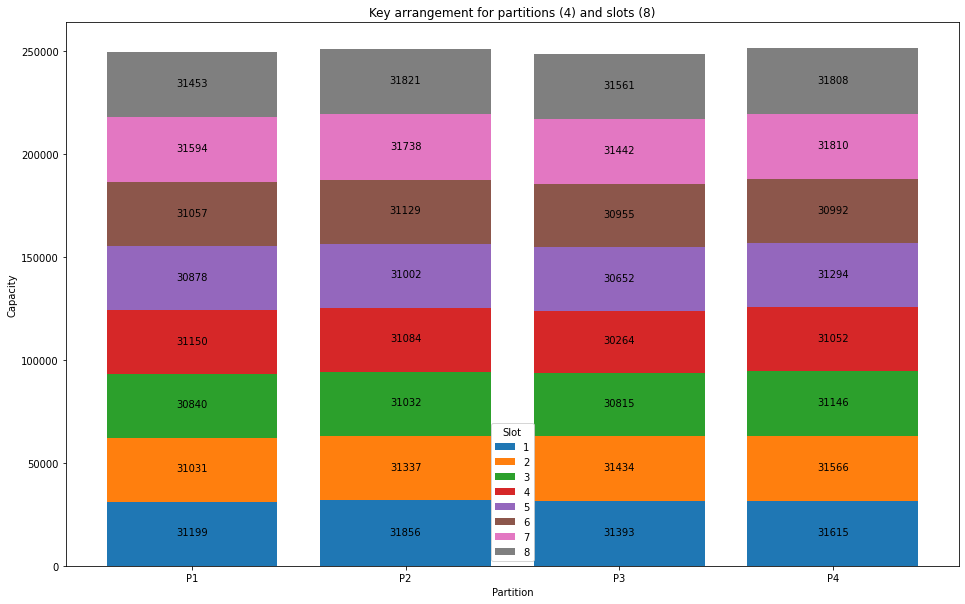

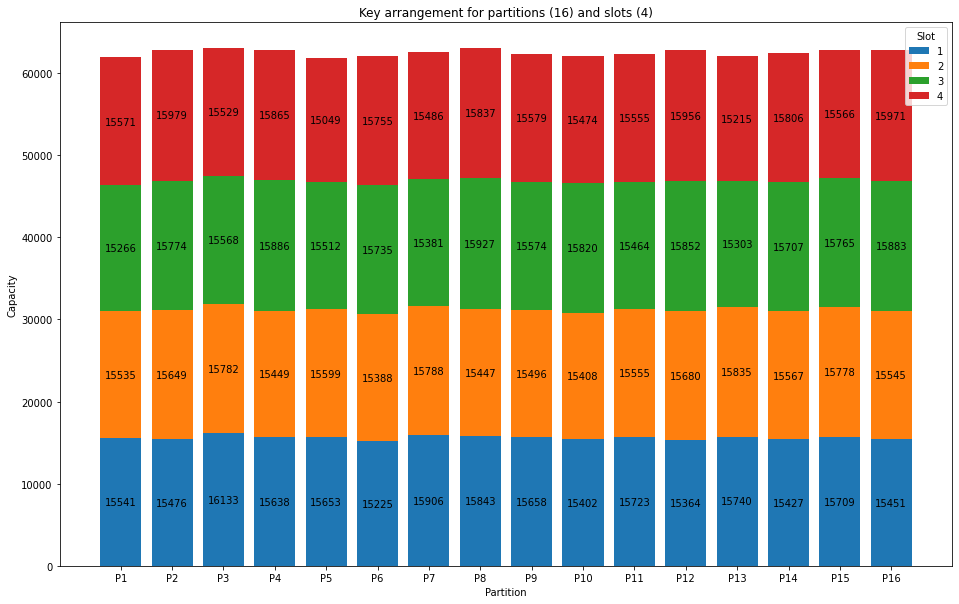

In [4]:
arrangementKeyTest = KeyArrangement(hashes)

arrangementKeyTest.partitions, arrangementKeyTest.slots = (4, 8)
arrangementKeyTest.show()

arrangementKeyTest.partitions, arrangementKeyTest.slots = (16, 4)
arrangementKeyTest.show()